# Sample-specific Models
Outline:
- global vs. cluster vs. context regression (MSE and L2) with continuously-varying parameters
- global vs. cluster vs. context networks (L2) with continuously-varying parameters

Introduce gaps in the latent space to show that the context-encoder can reasonably fill these gaps while clustering cannot

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.cluster import KMeans
from contextualized.regression import ContextualizedRegression, RegressionTrainer
from contextualized.networks import ContextualizedCorrelation, NetworkTrainer

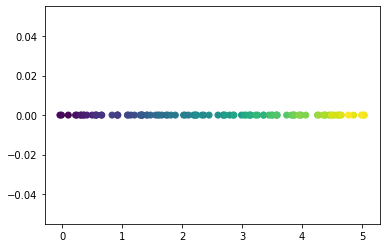

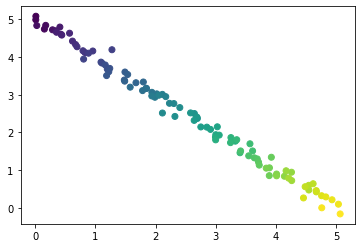

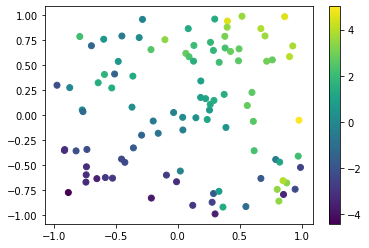

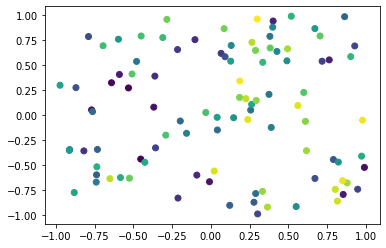

In [448]:
n_z = 100
Z = np.linspace(0, 5, n_z)
z_samples = 1
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()[:, np.newaxis]
C += np.random.normal(0, .1, C.shape)

W_true = np.array([Z, Z[::-1]]).T
W = np.repeat(W_true, z_samples, axis=0)
W += np.random.normal(0, .1, W.shape)
X = np.random.uniform(-1, 1, W.shape)
Y = (X * W).sum(axis=1)[:, np.newaxis]
Y += np.random.normal(0, .1, Y.shape)

plt.scatter(C, np.zeros_like(C), c=Z_labels)
plt.show()
plt.scatter(W[:,0], W[:,1], c=Z_labels)
plt.show()
plt.scatter(X[:,0], X[:,1], c=Y)
plt.colorbar()
plt.show()
plt.scatter(X[:,0], X[:,1], c=Z_labels)
plt.show()

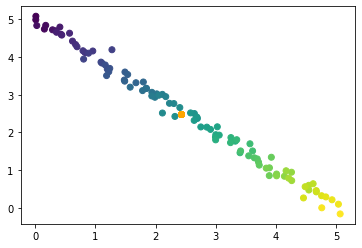

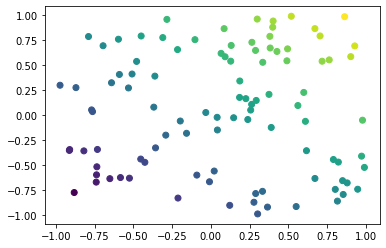

mse: 1.7191731337231595, l2: 2.126307637863274


In [449]:
# Global linear regression
w_global = np.linalg.inv(X.T @ X) @ X.T @ Y 
w_global = np.tile(w_global.T, (len(X), 1))
plt.scatter(W[:,0], W[:,1], c=Z_labels)
plt.scatter(w_global[:,0], w_global[:,1], c='orange')
plt.show()

y_hat = (X * w_global).sum(axis=1)[:,np.newaxis]
plt.scatter(X[:,0], X[:,1], c=y_hat)
plt.show()

mse = ((Y - y_hat)**2).mean()
l2 = ((W - w_global)**2).mean()
print(f"mse: {mse}, l2: {l2}")

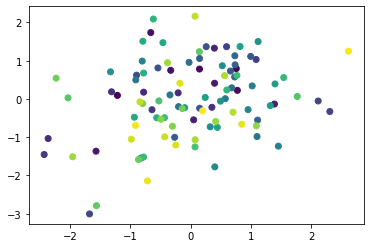

In [450]:
# noise-context sanity check
C_noise = np.random.normal(0, 1, W.shape)
C_noise = (C_noise - C_noise.mean(axis=0)) / C_noise.std(axis=0) 
model = ContextualizedRegression(C_noise.shape[-1], X.shape[-1], Y.shape[-1])

plt.scatter(C_noise[:,0], C_noise[:,1], c=Z_labels)
plt.show()

In [451]:
dataloader = model.dataloader(C_noise, X, Y, batch_size=1)
trainer = RegressionTrainer(max_epochs=20, auto_lr_find=True)
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 365   
-----------------------------------------------
365       Trainable params
0         Non-trainable params
365       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 99it [00:00, ?it/s]

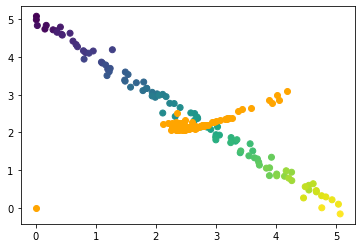

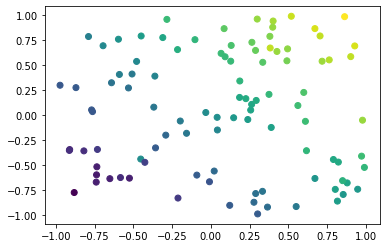

mse: 1.6658823624219141, l2: 2.2865142684735345


In [452]:
w_hat, mu = trainer.predict_params(model, dataloader)
w_hat = w_hat.squeeze()
y_hat = (X * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W[:,0], W[:,1], c=Z_labels)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X[:,0], X[:,1], c=y_hat)
plt.show()

mse = ((Y - y_hat)**2).mean()
l2 = ((W - w_hat)**2).mean()
print(f"mse: {mse}, l2: {l2}")

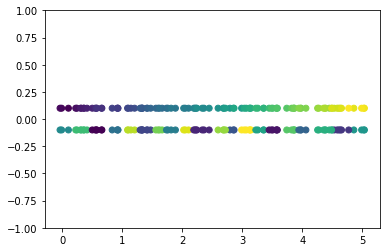

Overall mse: 0.014047401290153413, l2: 0.02778787914745196


In [457]:
# Context-clustered linear models
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters).fit(C)
labels = kmeans.labels_

plt.scatter(C, np.zeros_like(C) + .1, c=Z_labels)
plt.scatter(C, np.zeros_like(C) - .1, c=labels)
plt.ylim(-1, 1)
plt.show()

mses = []
l2s = []
for label in np.unique(labels):
    label_idx = labels == label
    X_c = X[label_idx]
    Y_c = Y[label_idx]
    W_c = W[label_idx]
    Z_c = Z_labels[label_idx]
    w_c = np.linalg.inv(X_c.T @ X_c) @ X_c.T @ Y_c 
    w_c = np.tile(w_c.T, (len(X_c), 1))
#     plt.scatter(W_c[:,0], W_c[:,1], c=Z_c)
#     plt.scatter(w_c[:,0], w_c[:,1], c='orange')
#     plt.show()

    y_c = (X_c * w_c).sum(axis=1)[:,np.newaxis]
#     plt.scatter(X_c[:,0], X_c[:,1], c=y_c)
#     plt.show()

    mse = ((Y_c - y_c)**2).mean()
    l2 = ((W_c - w_c)**2).mean()
#     print(f"mse: {mse}, l2: {l2}")
    mses.append(mse)
    l2s.append(l2)
print(f"Overall mse: {np.mean(mses)}, l2: {np.mean(l2)}")

In [460]:
# Contextualized model
model = ContextualizedRegression(C.shape[-1], X.shape[-1], Y.shape[-1])
dataloader = model.dataloader(C, X, Y, batch_size=1)
trainer = RegressionTrainer(max_epochs=20, auto_lr_find=True)
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 340   
-----------------------------------------------
340       Trainable params
0         Non-trainable params
340       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 99it [00:00, ?it/s]

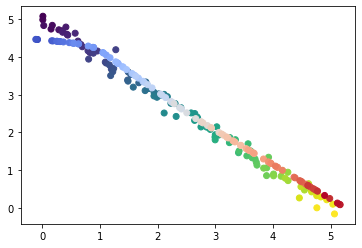

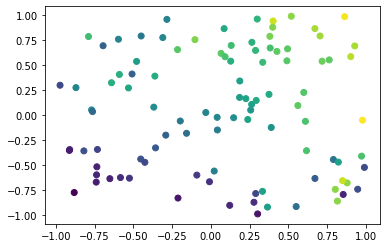

mse: 0.03273543844318585, l2: 0.036686739499540405


In [461]:
w_hat, _ = trainer.predict_params(model, dataloader)
w_hat = w_hat.squeeze()
w_hat[0] = w_hat[1]  # hotfix for trainer.predict_w artifact
y_hat = (X * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W[:,0], W[:,1], c=Z_labels)
plt.scatter(w_hat[:,0], w_hat[:,1], c=Z_labels, cmap='coolwarm')
plt.show()

plt.scatter(X[:,0], X[:,1], c=y_hat)
plt.show()

mse = ((Y - y_hat)**2).mean()
l2 = ((W - w_hat)**2).mean()
print(f"mse: {mse}, l2: {l2}")